Experiments using RandomForest on tablular data (trainData.csv and testData.csv files). 

In [ ]:
# @author: barisbozkurt
import os
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

In [ ]:
# This code consumes data files created by the dataProcessPipeline.py script

# Unpacking data from different annotators with and without manually corrected onsets
data_packages = ['rhythm_data4ML_0.zip','rhythm_data4ML_1.zip','rhythm_data4ML_2.zip',
                 'rhythm_data4ML_0_withCorrectedOnsets.zip',
                 'rhythm_data4ML_1_withCorrectedOnsets.zip',
                 'rhythm_data4ML_2_withCorrectedOnsets.zip',
                 'rhythm_data4ML_full_agree_correctedOnsets.zip']

data_folders = ['Expert0','Expert1','Expert2',
                'Expert0_CorrectedOnsets','Expert1_CorrectedOnsets','Expert2_CorrectedOnsets',
                'All_experts_full_agree_withCorrectedOnsets']

#Unzipping packages into folders
for data_folder, data_zip_file in zip(data_folders, data_packages):
  if not os.path.exists(data_folder):  # create folder if not exists
      os.mkdir(data_folder)
  zip_ref = zipfile.ZipFile(data_zip_file, 'r')
  zip_ref.extractall(data_folder)
  zip_ref.close()

In [ ]:
def read_balance_normalize_data(data_folder, train_file_path='trainData.csv', test_file_path='testData.csv'):
  # Read train and test data from csv files
  trainDF = pd.read_csv(os.path.join(data_folder, train_file_path))
  testDF = pd.read_csv(os.path.join(data_folder, test_file_path))
  annots_train_files = trainDF[['Per_file', 'grade']].set_index('Per_file').to_dict()['grade']
  annots_test_files = testDF[['Per_file', 'grade']].set_index('Per_file').to_dict()['grade']
  
  # deleting columns that carry file names
  del trainDF['Ref_file'] 
  del trainDF['Per_file']

  del testDF['Ref_file']
  del testDF['Per_file']

  # All columns except the last contain features, create matrix from data frame content
  X_train_val = trainDF.iloc[:, :-1].values
  X_test = testDF.iloc[:, :-1].values
  # Last column contains the grades, convert 1-4 to 0-3
  y_train_val = trainDF.grade.to_numpy() - 1
  y_test = testDF.grade.to_numpy() - 1

  # Balance train data
  over_sampler = SMOTE(k_neighbors=2)
  X_train_val, y_train_val = over_sampler.fit_resample(X_train_val, y_train_val)

  # Normalize features
  scaler = StandardScaler().fit(X_train_val)
  norm_x_train_val = scaler.transform(X_train_val)
  norm_x_test = scaler.transform(X_test)

  return norm_x_train_val, y_train_val, norm_x_test, y_test, annots_train_files, annots_test_files

----------------------------------------
RUNNING TESTS FOR  Expert0
Random forest , cross-val scores:	 [0.82257339 0.83516413 0.81922138 0.83001413 0.82339715] mean: 0.826074036521628
--------------Random forest--------------
              precision    recall  f1-score   support

           1       0.48      0.59      0.53      1567
           2       0.50      0.40      0.45      1693
           3       0.45      0.46      0.46      1568
           4       0.85      0.82      0.83      1689

    accuracy                           0.57      6517
   macro avg       0.57      0.57      0.57      6517
weighted avg       0.57      0.57      0.57      6517

----------------------------------------
RUNNING TESTS FOR  Expert1
Random forest , cross-val scores:	 [0.7919001  0.81221735 0.84663156 0.85621709 0.86850277] mean: 0.8350937745720464
--------------Random forest--------------
              precision    recall  f1-score   support

           1       0.48      0.63      0.55       120
   

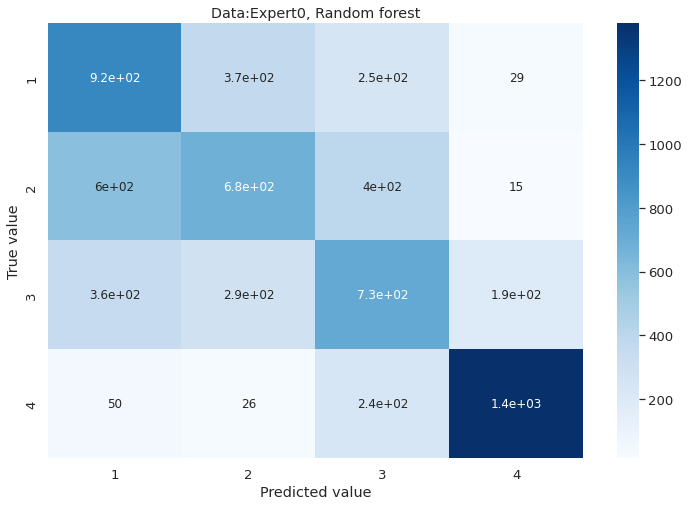

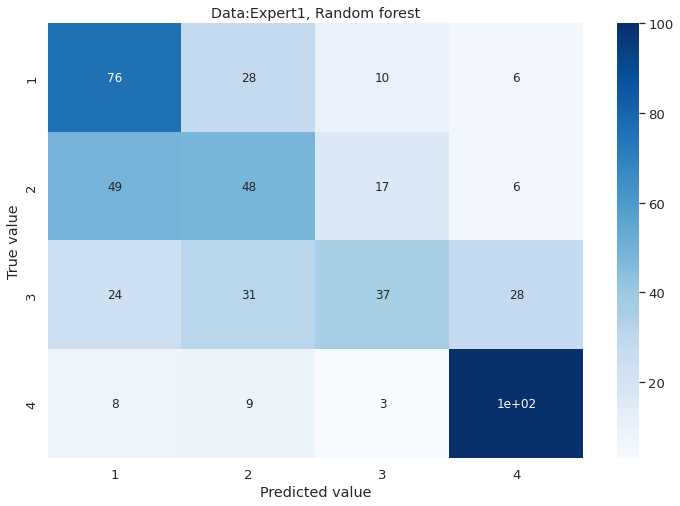

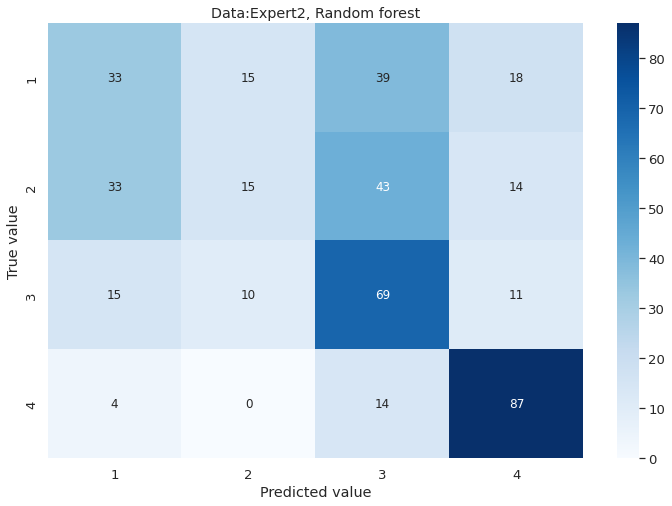

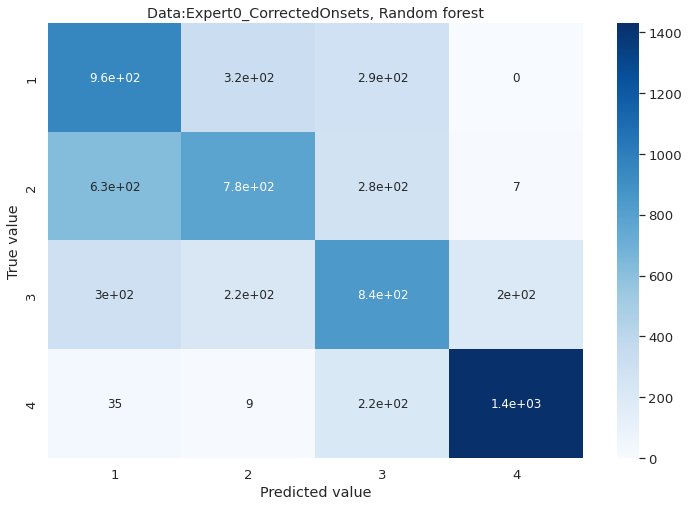

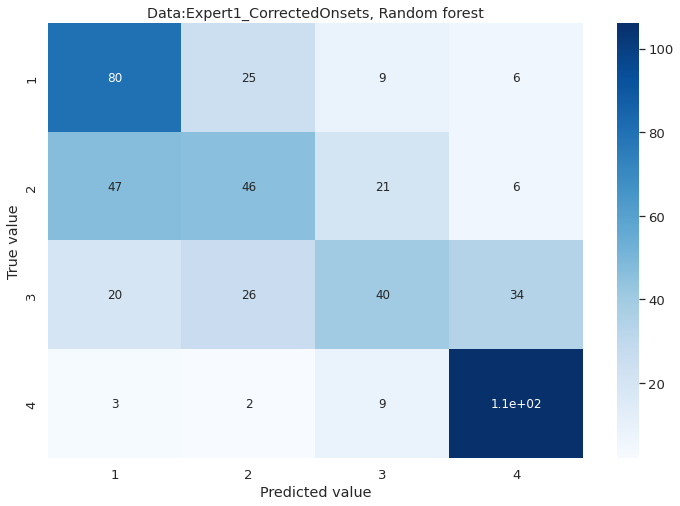

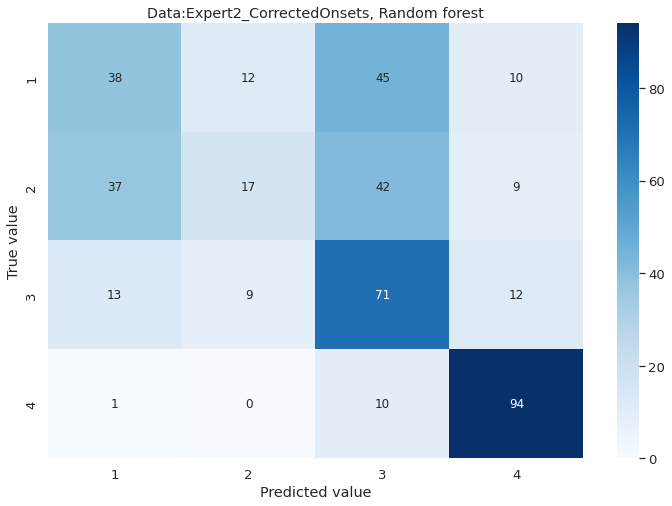

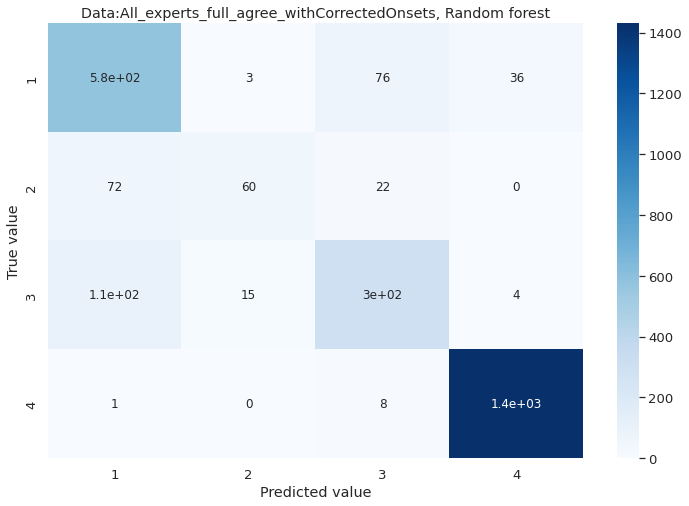

In [ ]:
# Cross-validation tests with Random Forest classifier with default parameters

classifiers2test = [RandomForestClassifier(random_state=0)] # you could add more classifiers here
classifier_names = ['Random forest'] # you could add more classifiers here

labels = np.arange(1,5)
labels_str = [str(val) for val in labels]

# Running cross-validation and then a single experiment with the test file for each data
num_cross_val_tests = 5
all_annots = {}
for data_folder in data_folders:
  print('-'*40)
  print('RUNNING TESTS FOR ', data_folder)
  norm_x_train_val, y_train_val, norm_x_test, y_test, annots_train_files, annots_test_files = read_balance_normalize_data(data_folder)
  all_annots[data_folder] = (annots_train_files, annots_test_files)
  scores = {}
  for name, classifier2test in zip(classifier_names, classifiers2test):
    scores[name] = cross_val_score(classifier2test, norm_x_train_val, y_train_val, cv=num_cross_val_tests)
    print(name, ', cross-val scores:\t', scores[name], 'mean:', np.mean(scores[name]))

    # Running single experiment: training with train_val and testing with test data
    print('--------------{}--------------'.format(name))
    classifier2test.fit(norm_x_train_val, y_train_val)
    y_pred = classifier2test.predict(norm_x_test)
    conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred),
                            columns=labels, index=labels)
    conf_mat.index.name = 'True value'
    conf_mat.columns.name = 'Predicted value'
    plt.figure(figsize=(12, 8))
    sns.set(font_scale=1.2)
    sns.heatmap(conf_mat, cmap='Blues', annot_kws={'size': 12}, annot=True)
    plt.title('Data:'+data_folder+', '+name)
    print(classification_report(y_test, y_pred, target_names=labels_str))